[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/peteyeh/celltrack/HEAD)

In [1]:
%matplotlib inline

import cv2
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import six

from collections import Counter, OrderedDict
from radiomics import featureextractor
from SimpleITK import GetImageFromArray
from skimage.filters import threshold_multiotsu
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from displaytools import *
from improcessing import *

extractor = featureextractor.RadiomicsFeatureExtractor()
# Enable everything but shape (3D) and glcm.SumAverage
extractor.disableAllFeatures()
extractor.enableFeaturesByName(firstorder=[],
                               shape2D=[],
                               glcm=['Autocorrelation', 'JointAverage', 'ClusterProminence',
                                     'ClusterShade', 'ClusterTendency', 'Contrast',
                                     'Correlation', 'DifferenceAverage', 'DifferenceEntropy',
                                     'DifferenceVariance', 'JointEnergy', 'JointEntropy',
                                     'Imc1', 'Imc2', 'Idm', 'Idmn', 'Id', 'Idn',
                                     'InverseVariance', 'MaximumProbability', 'SumEntropy',
                                     'SumSquares'],
                               glszm=[],
                               glrlm=[],
                               ngtdm=[],
                               gldm=[])

scaler = StandardScaler()
pca = PCA(n_components='mle')
tsne = TSNE(learning_rate='auto', init='pca', random_state=0)

In [2]:
# Clips pixel values and redistributes across 0-255
def clip_image(image, min_val=0, max_val=255):
    clipped = np.clip(image, a_min=min_val, a_max=max_val)
    return np.uint8((np.uint16(clipped)-min_val) * 255 / (max_val-min_val))

# Crops image to a region of interest
def crop_image(image):
    x, y, w, h = cv2.boundingRect(image)
    return image[y:y+h, x:x+w]

def display_classifications(image, centroids, labels):
    c = Counter(labels)
    for k in sorted(c):
        print("Class %s: %i (%.2f%%)" % (k, c[k], c[k]*100/sum(c.values())))
    plt.figure(dpi=240)
    plt.axis('off')
    plt.imshow(image, interpolation='nearest', cmap='gray')
    plt.scatter(*zip(*centroids), s=20, c=labels, marker='+', cmap=colormap, linewidths=1)
    plt.show()
    
def display_rois(image, masks, labels):
    for c in range(labels.min(), labels.max()+1):
        indices = np.where(labels==c)[0]
        print("Class %i, with %i ROIs:" % (c, len(indices)))
        masked = image*masks[indices]
        cropped = list(map(crop_image, masked))
        display_image_array(cropped, columns=10, dpi=300)

def display_tsne(df):
    transformed = tsne.fit_transform(df)
    plt.scatter(transformed[:,0], transformed[:,1], s=5, c=labels)
    plt.show()

def extract_features(image, mask_image, size_thresh=75):
    num_components, labelled, stats, centroids = \
            cv2.connectedComponentsWithStats(mask_image, connectivity=8)

    features = OrderedDict()
    masks = []

    for i in range(1, len(stats)):  # index 0 is the background component
        size = stats[i, -1]
        if size < size_thresh:
            continue
        mask = np.uint8(labelled == i)
        masks += [mask,]
        result = extractor.execute(GetImageFromArray(image),
                                   GetImageFromArray(mask))
        if len(features) == 0:
            features['x'] = [int(centroids[i][0])]
            features['y'] = [int(centroids[i][1])]
            for key, val in six.iteritems(result):
                if key.startswith("original_"):
                    features[key] = [val]
        else:
            features['x'] += [int(centroids[i][0])]
            features['y'] += [int(centroids[i][1])]
            for key, val in six.iteritems(result):
                if key.startswith("original_"):
                    features[key] += [val]

    return pd.DataFrame.from_dict(features).set_index(['x', 'y']), np.array(masks)

def get_mask_image(image, params, display_images=False):
    if params['min_val'] == 0 and params['max_val'] == 255:
        binarized = cv2.adaptiveThreshold(image, 255,
                                          cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                          cv2.THRESH_BINARY_INV,
                                          params['thresh_ks'], params['C'])
    else:
        image = clip_image(image, params['min_val'], params['max_val'])
        threshold, binarized = \
            cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    
    filled = apply_imfill(apply_closure(binarized, kernel_size=params['closure_ks']))

    if display_images:
        display_image_array([image, binarized, filled], columns=3, dpi=450)

    return filled

def process_features(df):
    return pd.DataFrame(pca.transform(scaler.transform(df.values)),
                        index=df.index)

# User-defined parameters

In [3]:
params = {
    # image closure kernel size
    'closure_ks': 3,

    # adaptive thresholding params
    'thresh_ks': 151,
    'C': 8,

    # pixel value clipping, set to 0 and 255 to disable
    'min_val': 85,
    'max_val': 140,
}

# Classification colors (include as many colors as classes)
colormap = matplotlib.colors.ListedColormap(['yellow', 'red', 'cyan'])

# Fit and classify on control image

## Create mask image and extract raw features

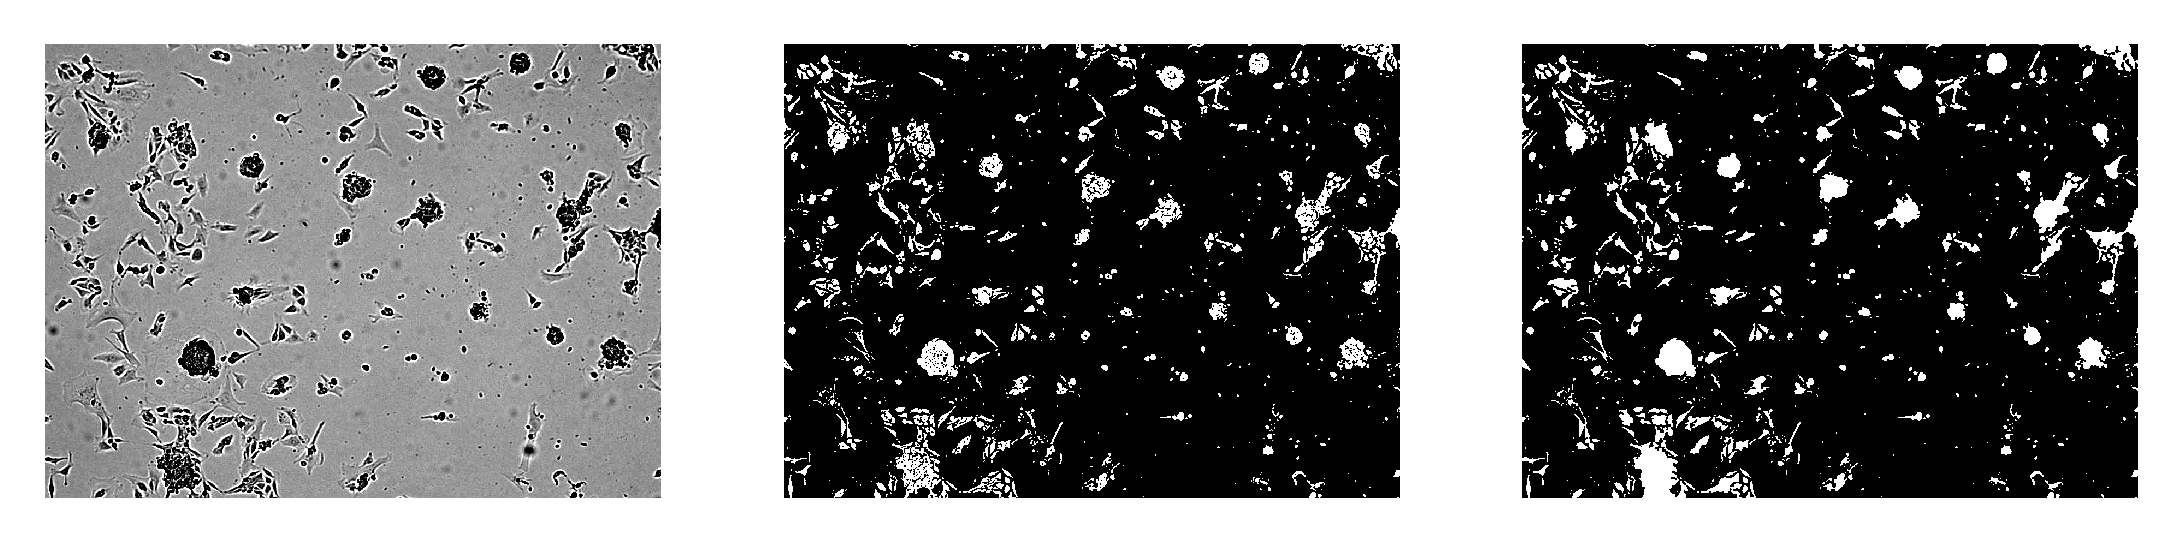

original_shape2D_Elongation  original_shape2D_MajorAxisLength  \
x   y                                                                    
476 3                       0.639776                         15.237390   
541 14                      0.507905                         31.597727   
575 3                       0.407083                         24.662635   
621 7                       0.813564                         15.754650   
753 2                       0.196692                         31.834964   
...                              ...                               ...   
419 818                     0.388545                         38.371905   
177 810                     0.471977                         21.999913   
407 815                     0.619514                         13.852336   
169 825                     0.640256                         17.543275   
101 823                     0.429863                         24.797620   

        original_shape2D_MaximumDiameter original_shape2D_MeshSurface  \
x   y                                                                   
476 3                  16.76305461424021                        103.5   
541 14                 30.01666203960727                        324.5   
575 3                 25.317977802344327                        180.5   
621 7                  16.15549442140351                        151.5   
753 2                 30.083217912982647                        118.5   
...                                  ...                          ...   
419 818                33.52610922848042                        197.5   
177 810                24.08318915758459                        172.5   
407 815               14.317821063276353                         91.5   
169 825                 19.4164878389476                        138.5   
101 823               27.459060435491963                        199.5   

         original_shape2D_MinorAxisLength original_shape2D_Perimeter  \
x   y                                                                  
476 3                            9.748512           43.7989898732233   
541 14                          16.048646          88.18376618407362   
575 3                           10.039748          65.79898987322329   
621 7                           12.817416          50.62741699796948   
753 2                            6.261690           68.6274169979695   
...                                   ...                        ...   
419 818                         14.909220         118.52691193458128   
177 810                         10.383458          63.35533905932732   
407 815                          8.581717           38.6274169979695   
169 825                         11.232195          52.97056274847712   
101 823                         10.659571          67.69848480983495   

        original_shape2D_PerimeterSurfaceRatio  original_shape2D_PixelSurface  \
x   y                                                                           
476 3                       0.4231786461180995                          104.0   
541 14                     0.27175274632996493                          325.0   
575 3                       0.3645373400178576                          181.0   
621 7                      0.33417436962356095                          152.0   
753 2                       0.5791343206579705                          119.0   
...                                        ...                            ...   
419 818                     0.6001362629599052                          198.0   
177 810                     0.3672773278801584                          173.0   
407 815                    0.42215756281933875                           92.0   
169 825                     0.3824589368121092                          139.0   
101 823                    0.33934077598914764                          200.0   

         original_shape2D_Sphericity original_firstorder_10Percentile  ...  \
x   y                      

In [4]:
raw_image = cv2.imreadmulti('source_images/Control.tif')[1][0]
mask_image = get_mask_image(raw_image, params, display_images=True)
df, masks = extract_features(raw_image, mask_image)
display(df)

## Scale features and reduce dimensions

In [5]:
scaler.fit(df.values)
pca.fit(df.values)

df = process_features(df)
display(df)

0            1          2           3           4   \
x   y                                                                   
476 3   -3.853481e+06 -2733.096453  97.590053 -354.284414  265.493958   
541 14  -3.853480e+06 -2732.731606  96.605535 -353.505403  264.800493   
575 3   -3.853481e+06 -2733.281460  97.433036 -354.544550  265.307703   
621 7   -3.853481e+06 -2733.854554  96.547389 -353.551305  265.274842   
753 2   -3.853481e+06 -2733.749238  96.671528 -353.829329  265.567639   
...               ...          ...        ...         ...         ...   
419 818 -3.853481e+06 -2733.711599  96.815737 -354.329765  265.659835   
177 810 -3.853481e+06 -2733.559104  97.011139 -354.388791  265.587911   
407 815 -3.853481e+06 -2733.204155  98.092099 -355.518867  265.637635   
169 825 -3.853481e+06 -2732.787656  98.595523 -355.333536  265.004435   
101 823 -3.853480e+06 -2732.656994  96.955641 -353.961191  265.038638   

                 5           6          7          8          9   ...  \
x   y                                                             ...   
476 3    206.700292 -146.505452  98.773388  20.762859 -76.406831  ...   
541 14   206.659294 -144.723208  97.553874  19.967462 -75.789737  ...   
575 3    206.895456 -145.830524  98.318518  20.805111 -75.812958  ...   
621 7    206.543131 -146.562286  98.701250  20.762329 -76.853091  ...   
753 2    206.577608 -145.969402  98.312746  21.094019 -76.137771  ...   
...             ...         ...        ...        ...        ...  ...   
419 818  207.115263 -145.231758  97.817632  21.387422 -75.463925  ...   
177 810  206.966918 -146.043846  98.407708  20.920946 -76.037743  ...   
407 815  206.900973 -145.861035  98.422593  20.461757 -74.698965  ...   
169 825  206.877122 -146.217159  98.773776  21.316073 -75.176695  ...   
101 823  206.514039 -145.163568  97.800715  20.599309 -74.723430  ...   

               87        88        89        90        91        92        93  \
x   y                                                                           
476 3   -0.478299 -0.486060 -0.439394 -0.215131 -0.649638 -0.838614  0.250660   
541 14  -0.193484  0.638753 -0.605057 -0.745601 -0.588347 -0.231722 -0.769030   
575 3   -0.318762  0.148621 -0.450240 -0.421060 -0.900570 -0.914379 -0.304733   
621 7   -0.712614  0.219193 -0.395874 -1.284658 -1.021890  0.000428  0.070936   
753 2   -0.379643  0.032298 -0.578032 -0.451288 -0.901361 -0.350324  0.092677   
...           ...       ...       ...       ...       ...       ...       ...   
419 818 -0.505580  0.070124  0.096957 -0.721948 -0.840642 -0.441410  0.022714   
177 810 -0.898327 -0.328861  0.064828 -0.942753 -1.238411 -0.606085  0.472211   
407 815 -0.805169 -0.530966  0.492951  0.123934 -0.749986 -2.212390  0.003171   
169 825 -0.919039 -0.925096  0.023804 -0.281982 -1.365456 -1.598918  1.176987   
101 823 -0.352580  0.254148 -0.549747 -0.793288 -0.491239 -0.370934 -0.260699   

               94        95        96  
x   y                                  
476 3    0.181633 -0.839777 -0.159291  
541 14   0.115614 -1.255480 -0.234993  
575 3    0.282644 -0.797804 -0.150212  
621 7    0.070042 -1.647373 -0.310215  
753 2    0.243035 -1.121355 -0.208769  
...           ...       ...       ...  
419 818  0.033431 -1.049688 -0.200186  
177 810  0.131550 -1.255491 -0.240867  
407 815  0.639017 -0.092477 -0.010554  
169 825  0.412561 -0.654991 -0.126978  
101 823  0.097851 -1.208550 -0.224785  

[206 rows x 97 columns]

## Determine number of clusters

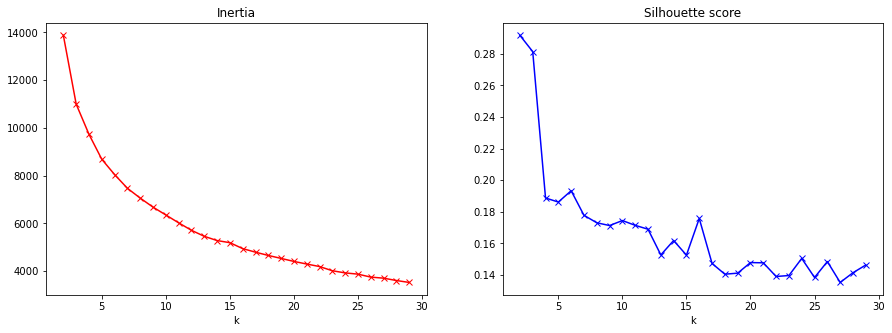

In [6]:
inertias = []
silhouette_scores = []
K = range(2, 30)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(df)
    inertias += [kmeans.inertia_,]
    silhouette_scores += [silhouette_score(df, labels),]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(K, inertias, 'rx-')
ax1.set(xlabel='k', title='Inertia')
ax2.plot(K, silhouette_scores,'bx-')
ax2.set(xlabel='k', title='Silhouette score')
plt.show()

## Fit and classify using silhouette score

Class 0: 31 (15.05%)
Class 1: 53 (25.73%)
Class 2: 122 (59.22%)


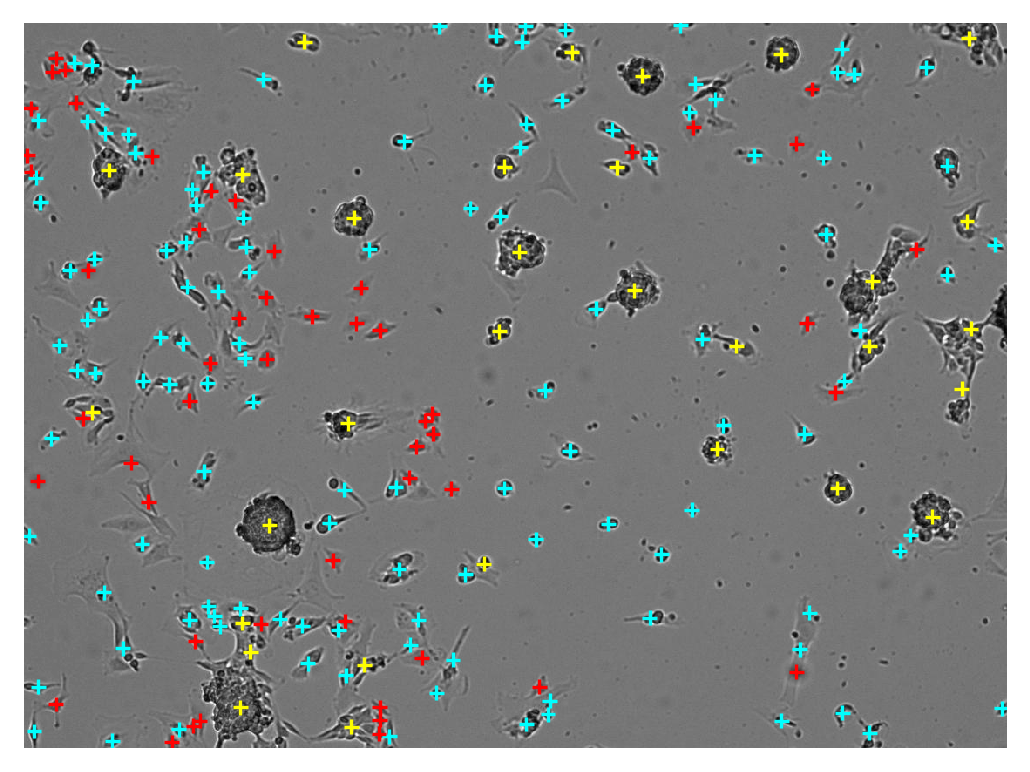

In [7]:
# Manually select 3 classes, this makes sense since the 2 primary classes
# are occasionally stacked atop one another.
k = 3  # np.argmax(silhouette_scores) + min(K)

kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(df)
labels = kmeans.predict(df)
display_classifications(raw_image, df.index, labels)

Class 0, with 31 ROIs:


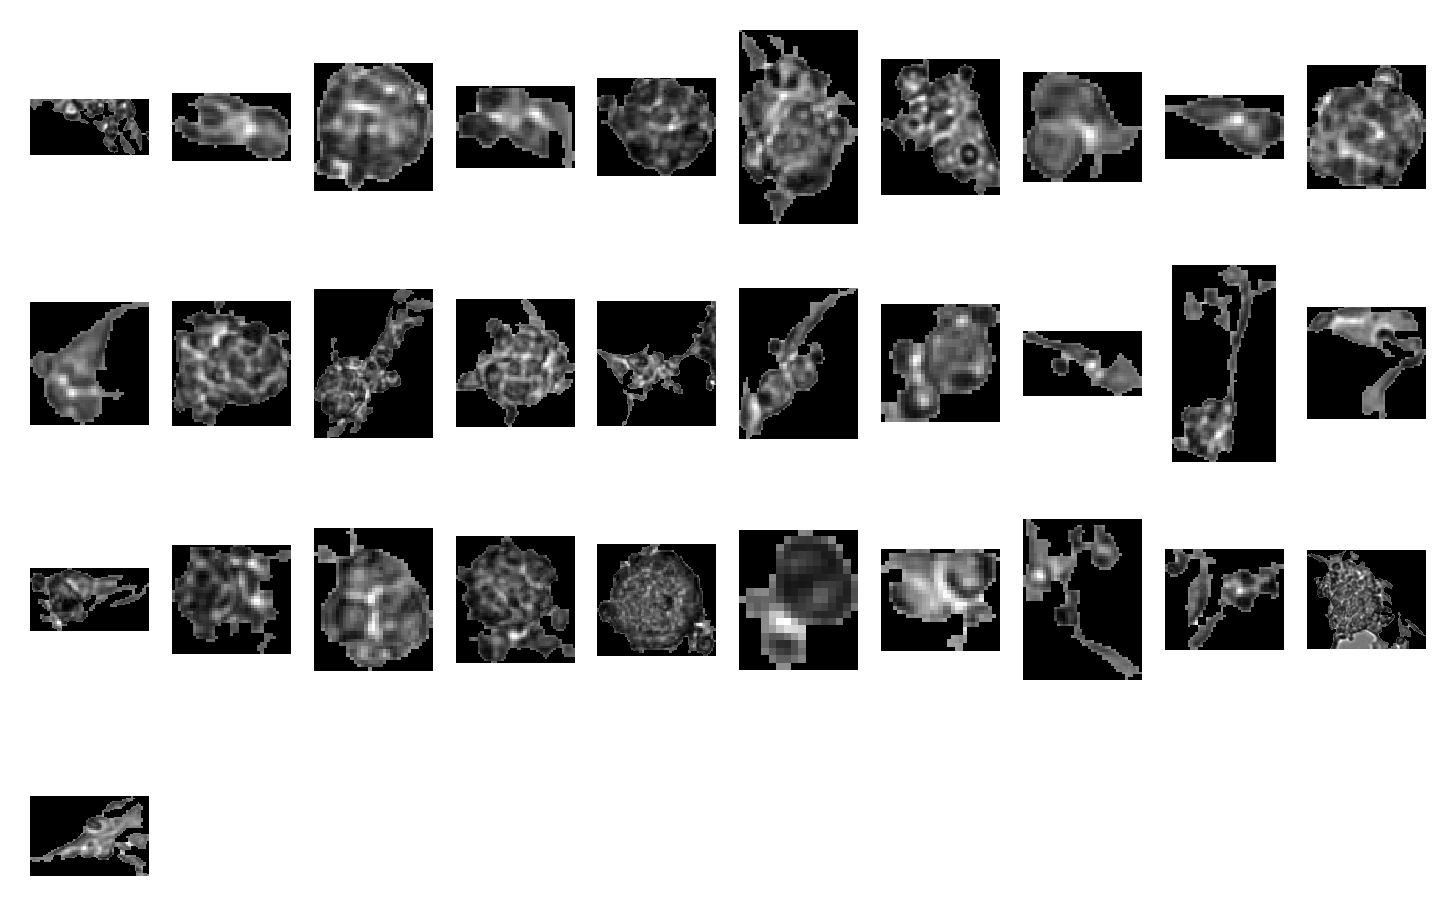

Class 1, with 53 ROIs:


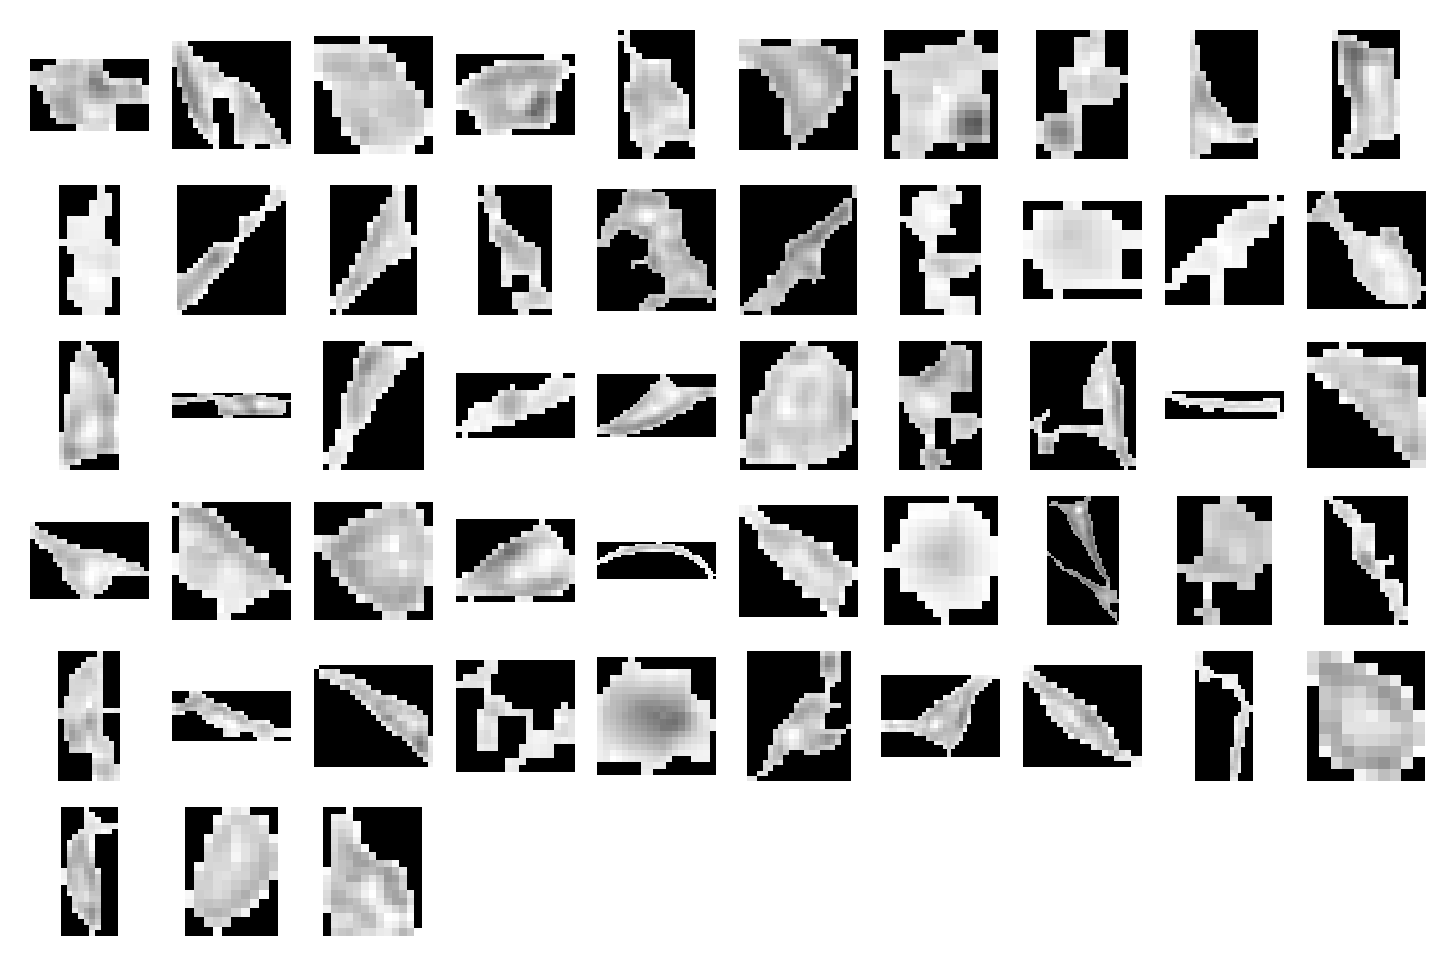

Class 2, with 122 ROIs:


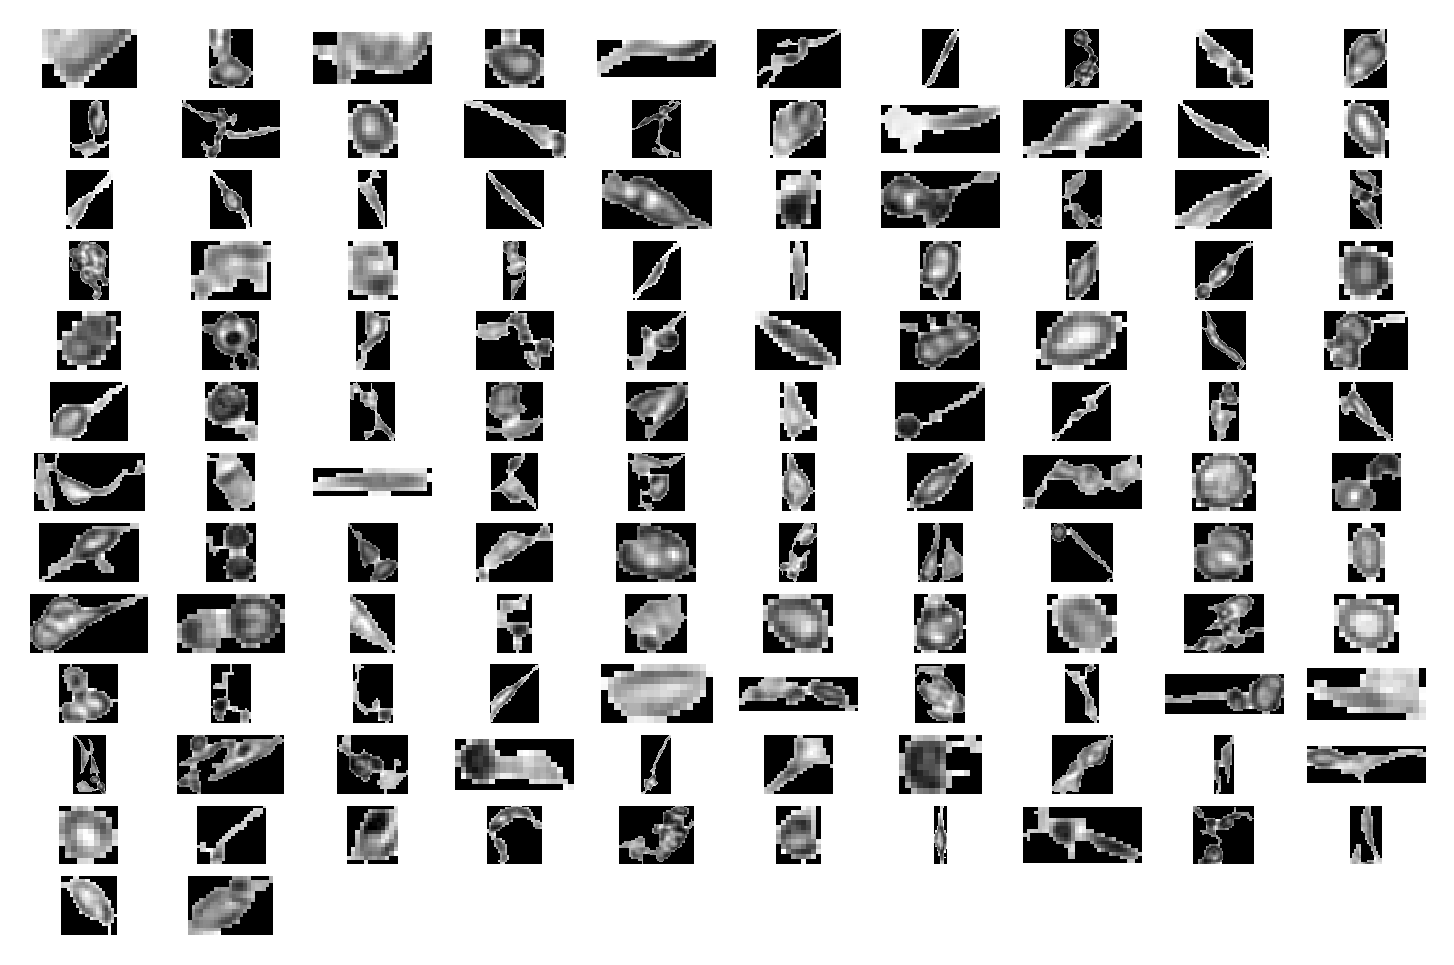

In [8]:
display_rois(raw_image, masks, labels)

## Cluster visualization

/Users/peteyeh/miniconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


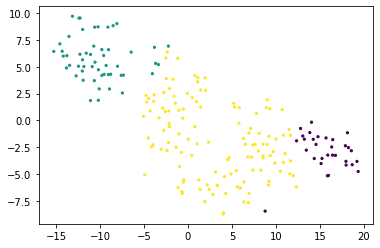

In [9]:
display_tsne(df)

# Experiment w/ multi-Otsu

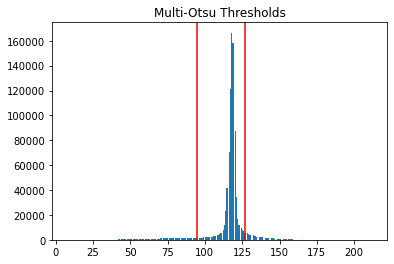

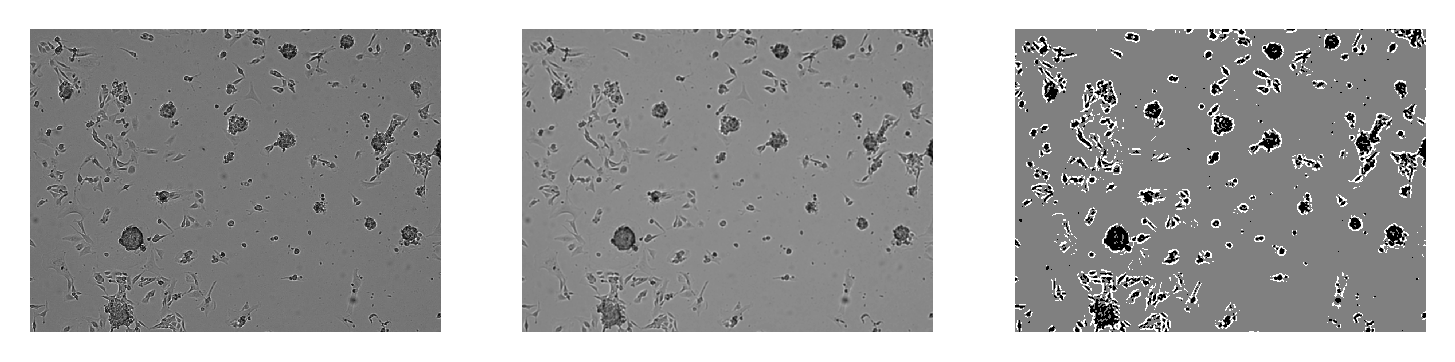

In [10]:
blurred = cv2.GaussianBlur(raw_image,(5,5),cv2.BORDER_DEFAULT)
thresholds = threshold_multiotsu(blurred)
multi_otsu_regions = np.digitize(blurred, bins=thresholds)

plt.hist(blurred.ravel(), bins=255)
plt.title('Multi-Otsu Thresholds')
for thresh in thresholds:
    plt.axvline(thresh, color='r')

display_image_array([raw_image, blurred, multi_otsu_regions],
                    columns=3, dpi=300)

# Classify cells on adherent image

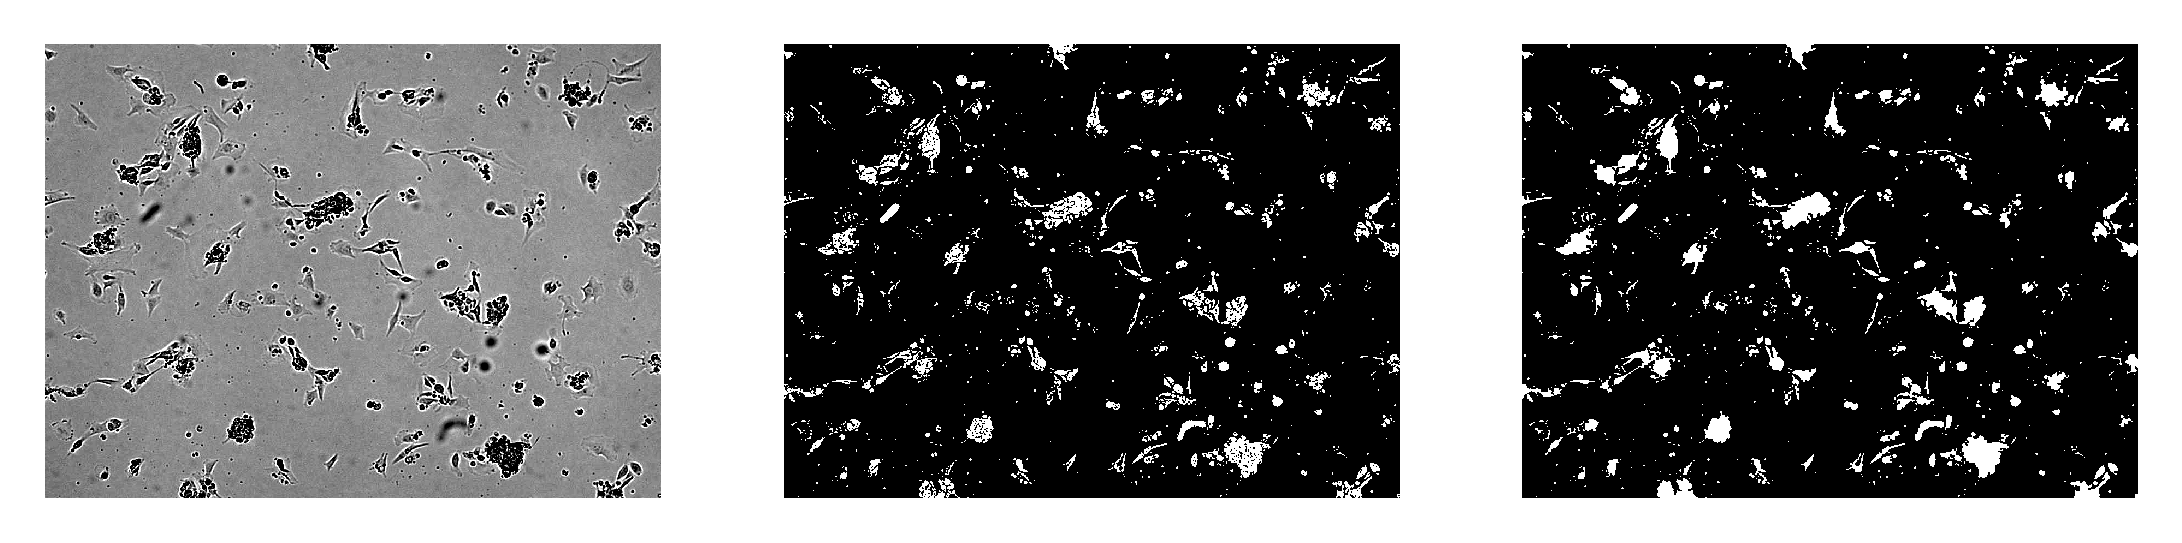

Class 0: 31 (21.68%)
Class 1: 40 (27.97%)
Class 2: 72 (50.35%)


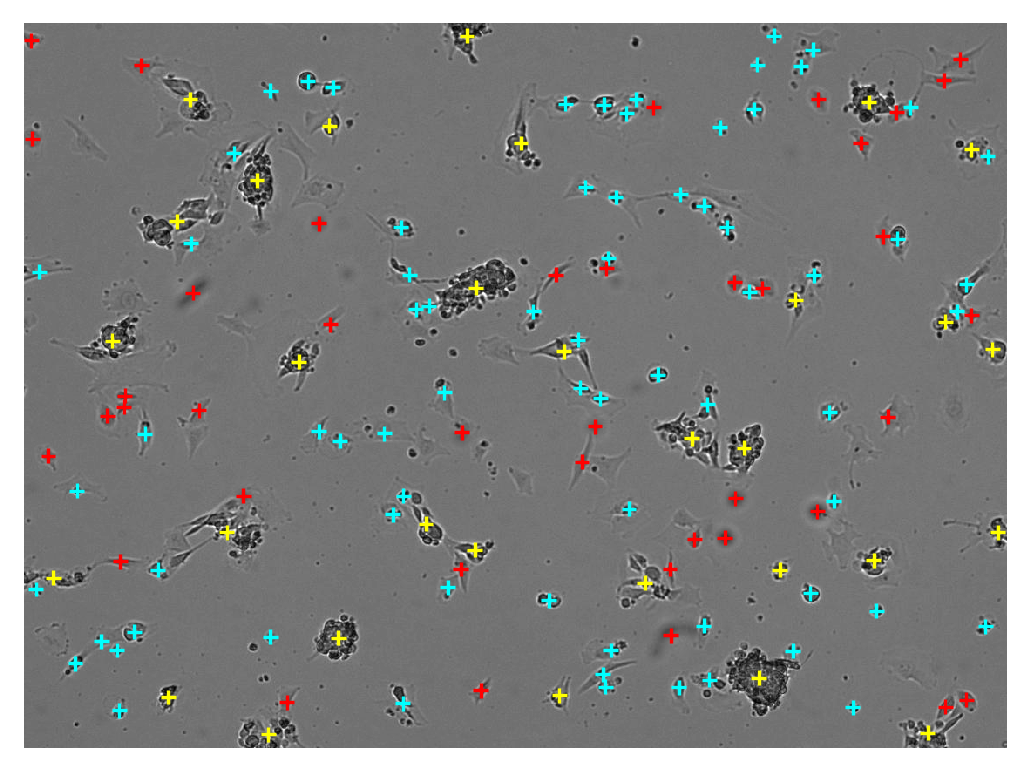

In [11]:
raw_image = cv2.imreadmulti('source_images/Adherent.tif')[1][0]
mask_image = get_mask_image(raw_image, params, display_images=True)
df, masks = extract_features(raw_image, mask_image)
df = process_features(df)
labels = kmeans.predict(df)
display_classifications(raw_image, df.index, labels)

Class 0, with 31 ROIs:


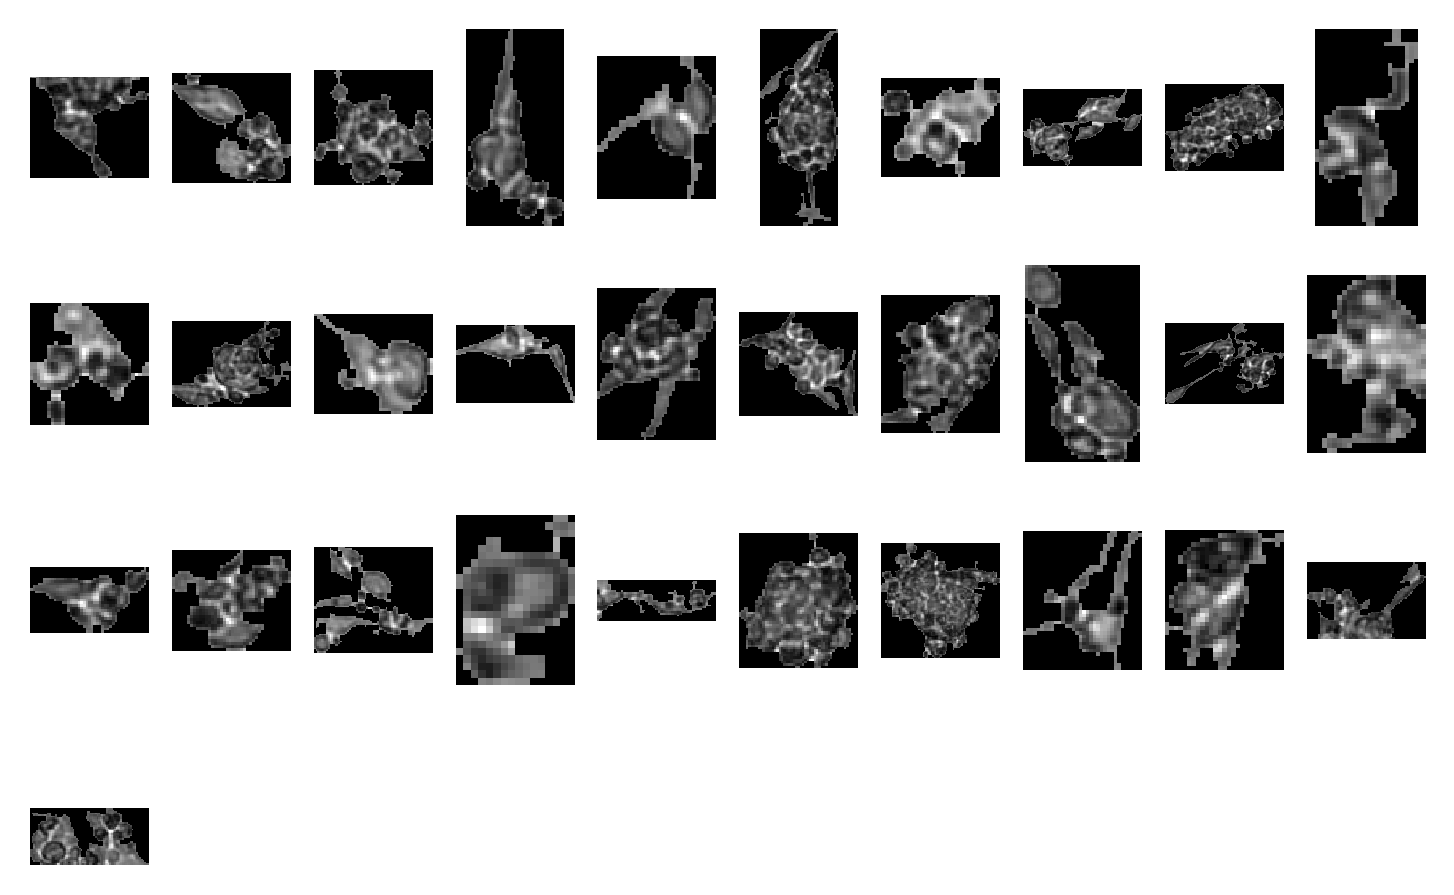

Class 1, with 40 ROIs:


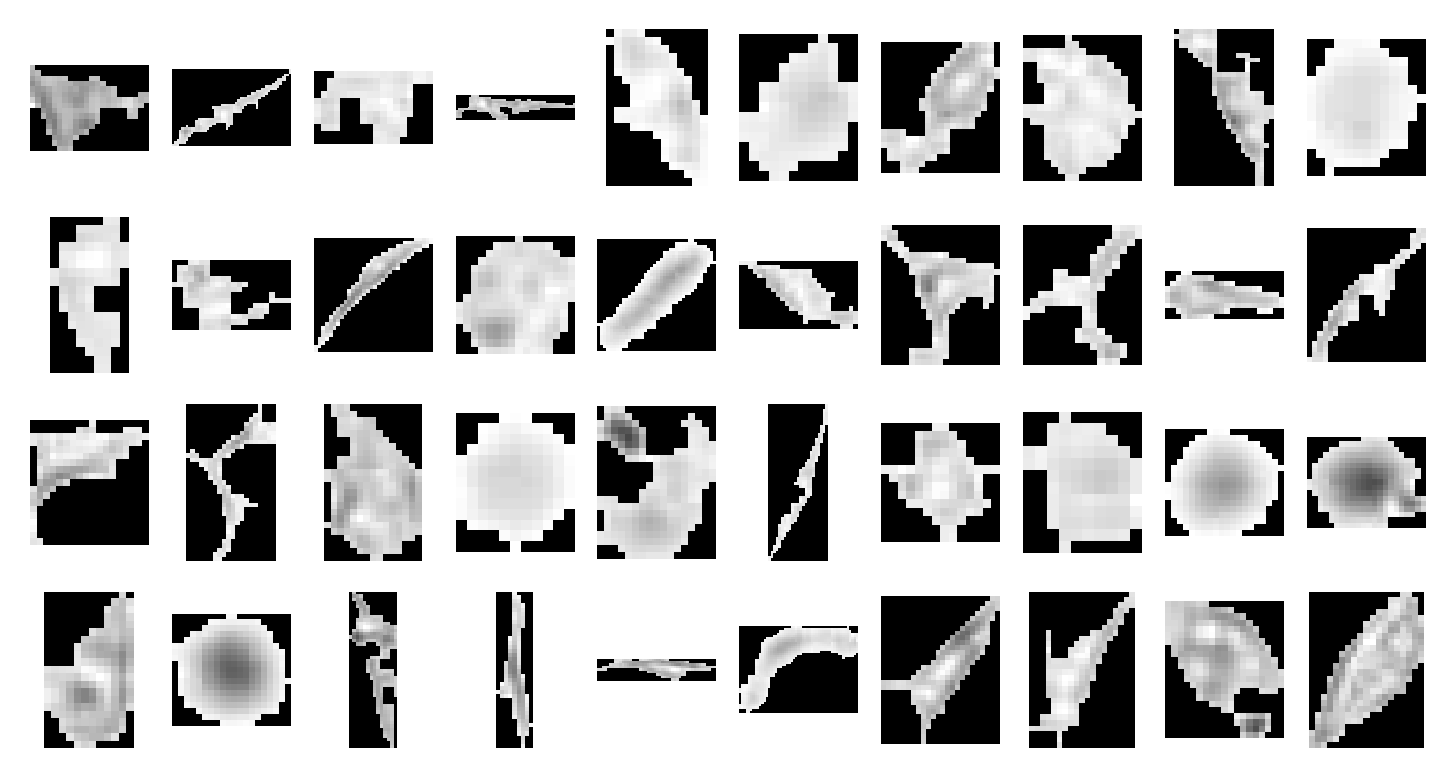

Class 2, with 72 ROIs:


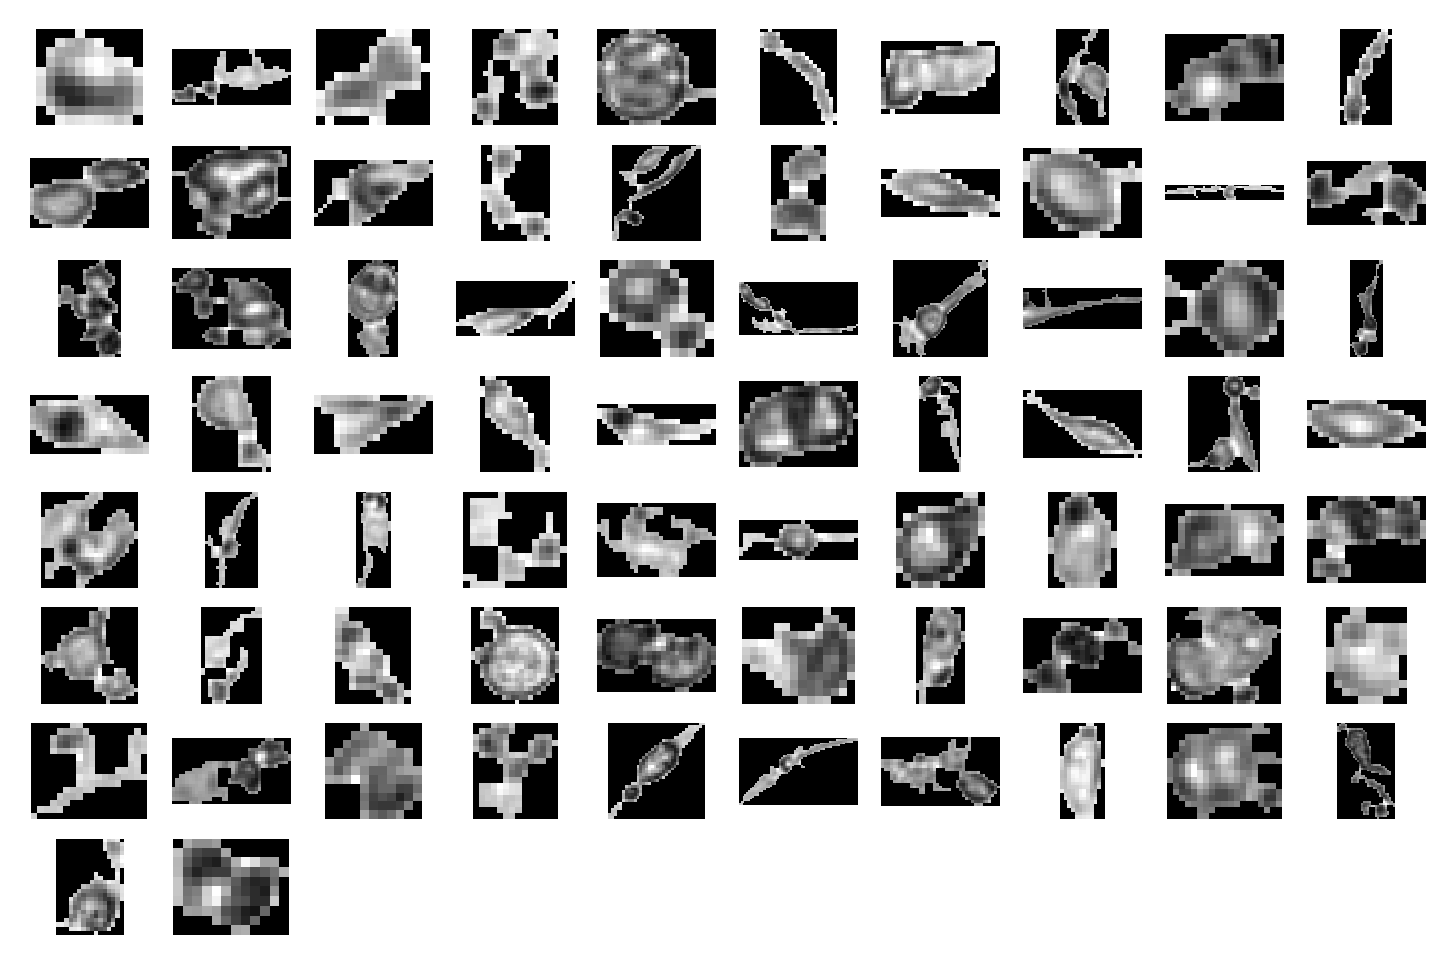

In [12]:
display_rois(raw_image, masks, labels)

/Users/peteyeh/miniconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


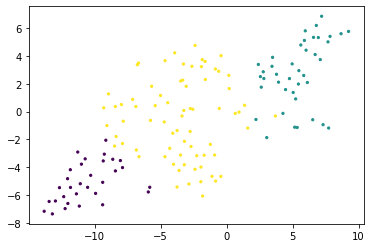

In [13]:
display_tsne(df)

# Classify cells on suspension image

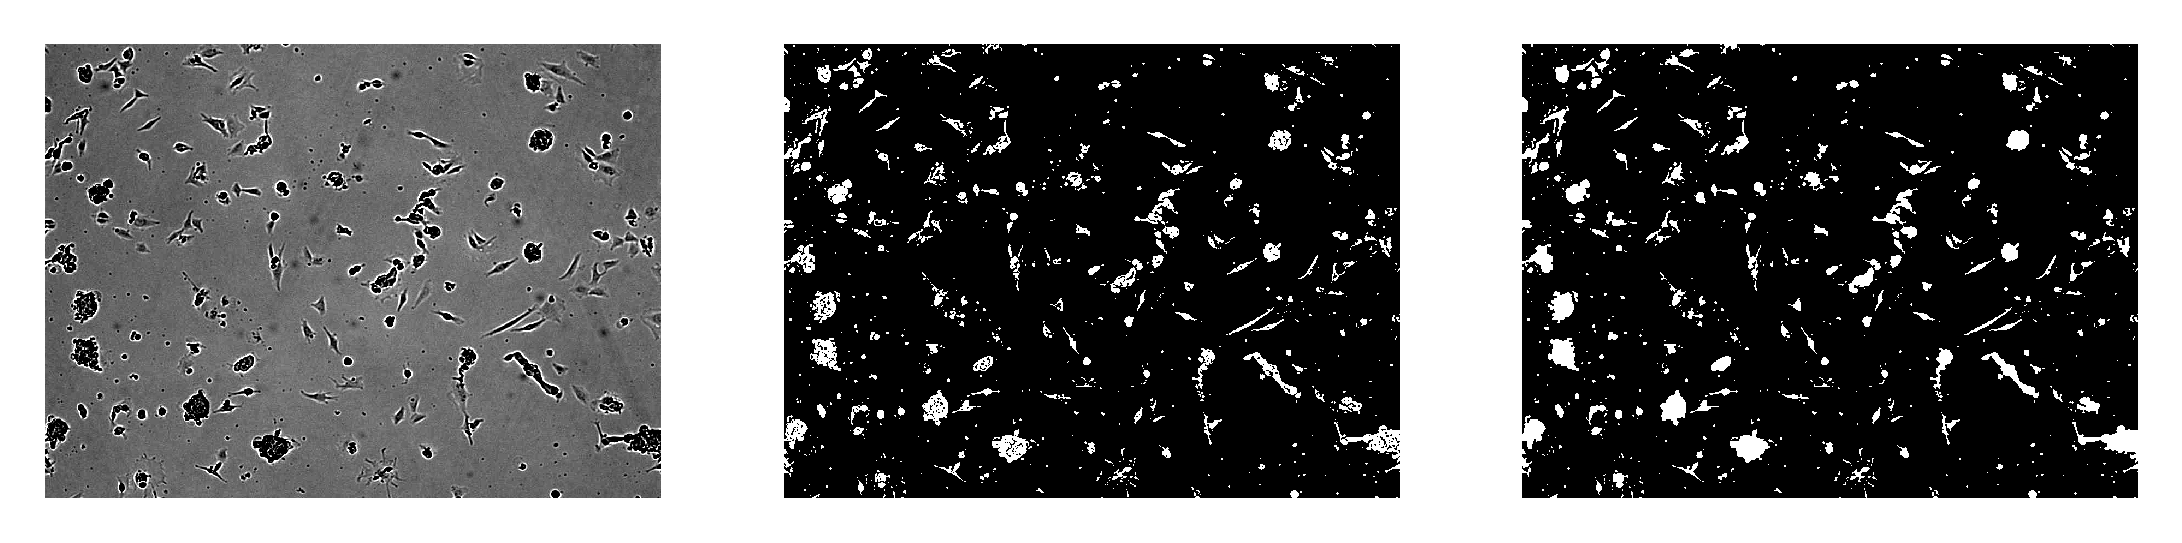

Class 0: 22 (14.01%)
Class 1: 66 (42.04%)
Class 2: 69 (43.95%)


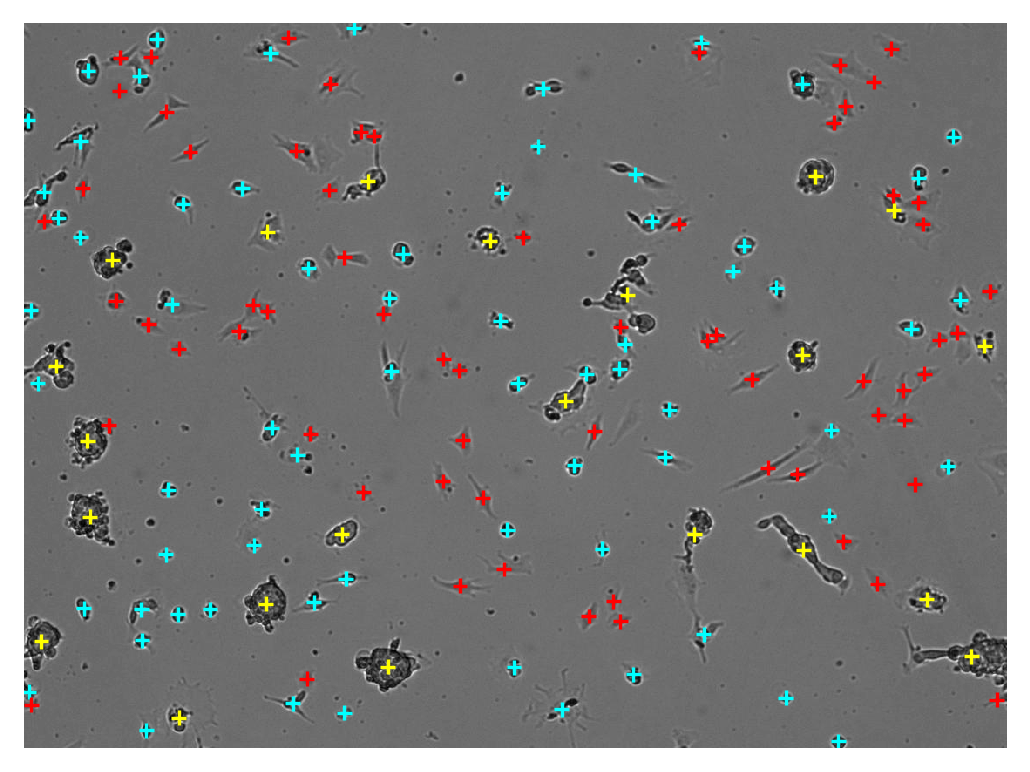

In [14]:
raw_image = cv2.imreadmulti('source_images/Suspension.tif')[1][0]
mask_image = get_mask_image(raw_image, params, display_images=True)
df, masks = extract_features(raw_image, mask_image)
df = process_features(df)
labels = kmeans.predict(df)
display_classifications(raw_image, df.index, labels)

Class 0, with 22 ROIs:


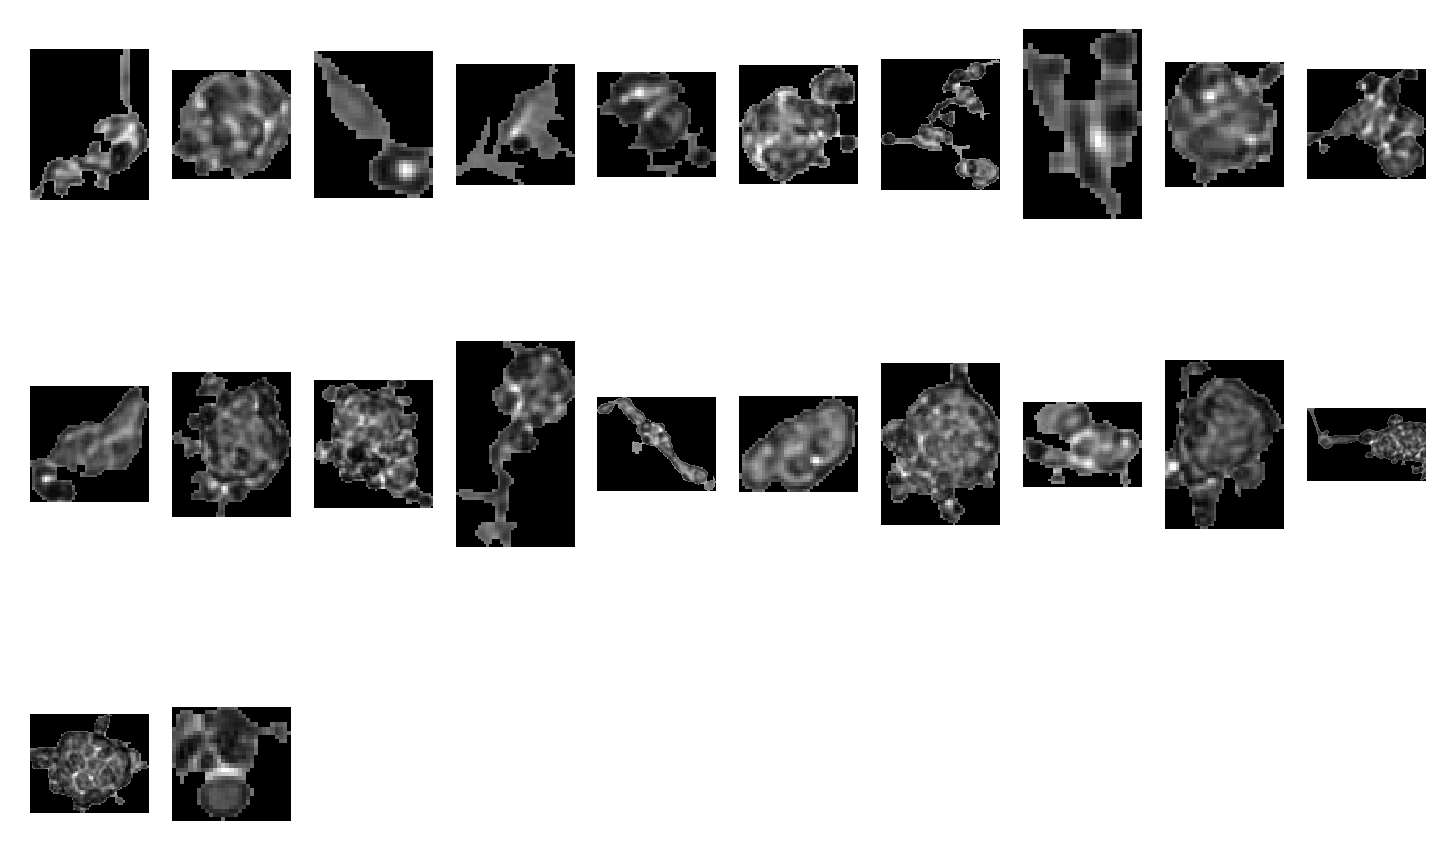

Class 1, with 66 ROIs:


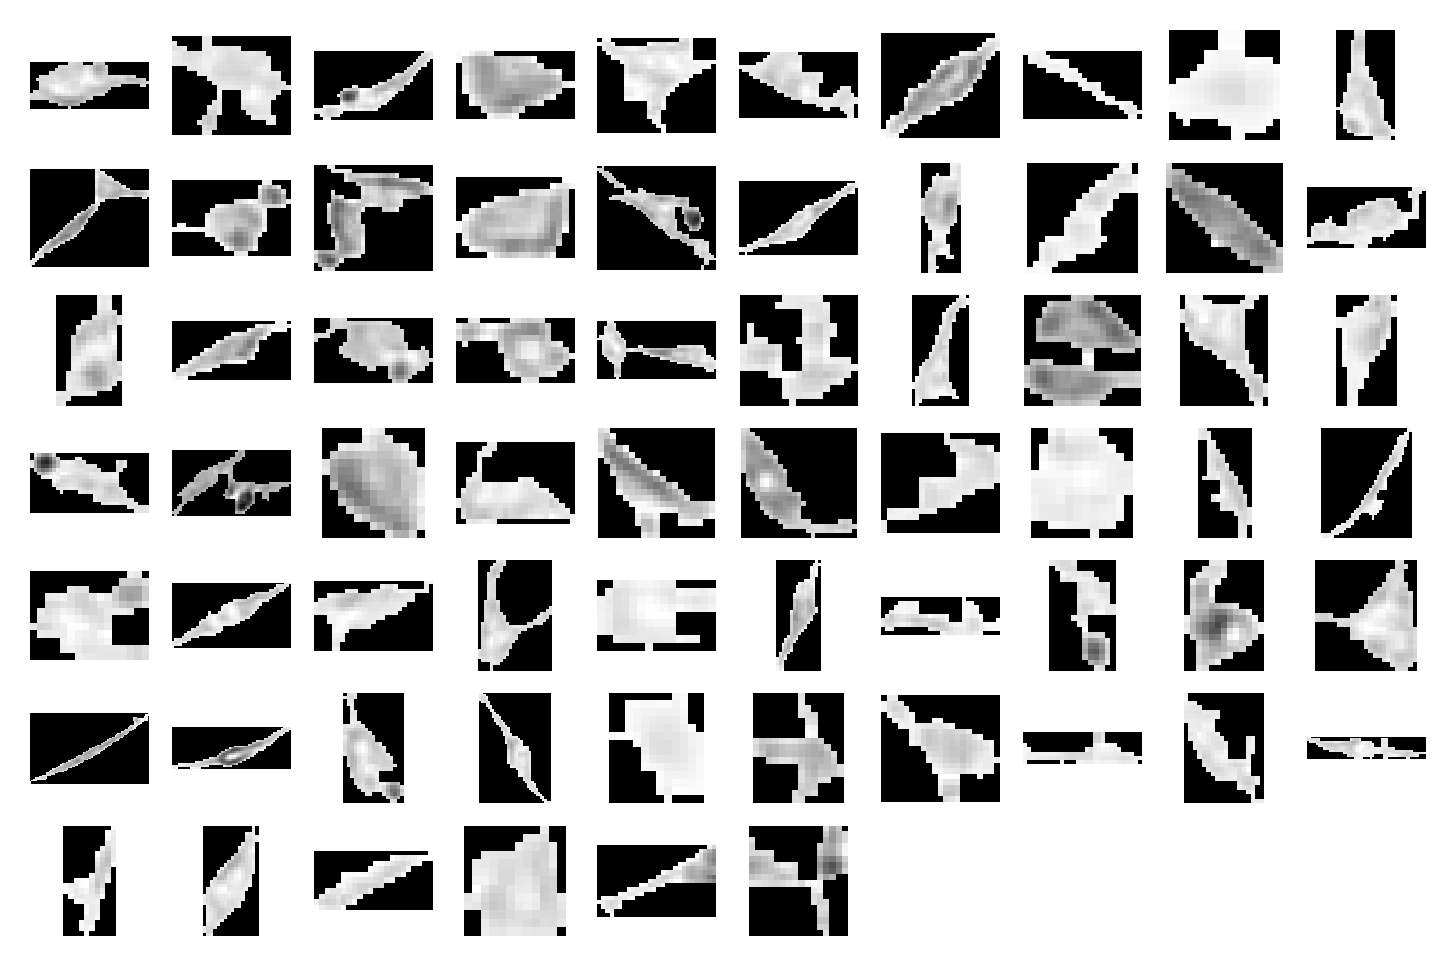

Class 2, with 69 ROIs:


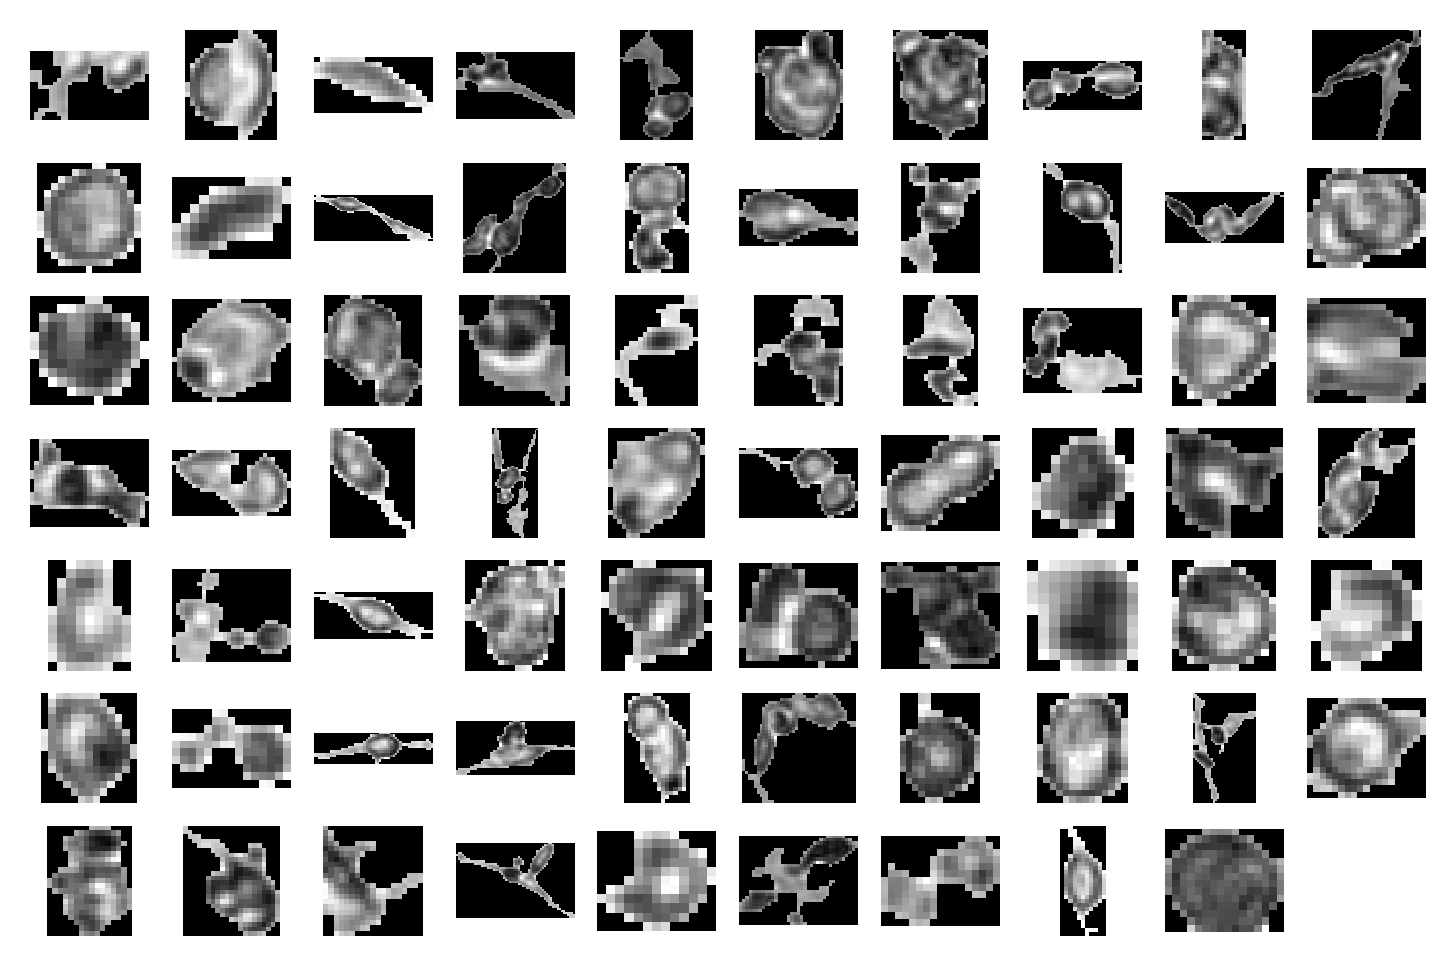

In [15]:
display_rois(raw_image, masks, labels)

/Users/peteyeh/miniconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


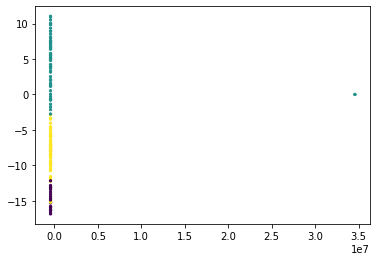

In [16]:
display_tsne(df)